Lootbox project: Machine learning prediction

In this notebook I'll try to train a ML model that will predict whether a user in the *Behavioral Characteristics of Internet Gamblers Who Trigger Corporate Responsible Gambling Interventions* dataset shows signs of addictive behavior or not.

In [1]:
import pandas as pd

Load the daily aggregate dataset

In [2]:
df_daily_agg = pd.read_csv('../Raw Datset II.Daily aggregates_Gray_LaPlante_PAB_2012.dat', delimiter='\t')

/tmp/ipykernel_3035041/1940407291.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_daily_agg = pd.read_csv('../Raw Datset II.Daily aggregates_Gray_LaPlante_PAB_2012.dat', delimiter='\t')


Load the analytic dataset

In [3]:
df_analytic = pd.read_csv('../AnalyticDataset_Gray_LaPlante_PAB_2012.dat', delimiter='\t')
df_analytic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 97 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   UserID                                4132 non-null   int64 
 1   RG_case                               4132 non-null   int64 
 2   Missing_Daily_Transactions            4132 non-null   int64 
 3   First_Deposit_Date                    4132 non-null   object
 4   Registration_date                     4132 non-null   object
 5   CountryName                           4132 non-null   object
 6   LanguageName                          4132 non-null   object
 7   Gender                                4132 non-null   object
 8   YearofBirth                           4132 non-null   object
 9   age_at_registration                   4132 non-null   object
 10  sum_stakes_fixedodds                  4132 non-null   object
 11  sum_bets_fixedodds            

In [4]:
display(df_analytic.sample(5))

,UserID,RG_case,Missing_Daily_Transactions,First_Deposit_Date,Registration_date,CountryName,LanguageName,Gender,YearofBirth,age_at_registration,...,percent_lost_liveaction_sqrt_zeros,sum_stakes_casino_sqrt_zeros,sum_bets_casino_sqrt_zeros,bettingdays_casino_sqrt_zeros,duration_casino_sqrt_zeros,frequency_casino_sqrt_zeros,bets_per_day_casino_sqrt_zeros,euros_per_bet_casino_sqrt_zeros,net_loss_casino_sqrt_zeros,percent_lost_casino_sqrt_zeros
1964,4006708,1,0,11/22/2006,11/21/2006,Germany.COM,German,M,1981,24,...,2.83792477931084,0,0,0,0,0,0,0,0,0
1605,3239668,0,0,6/22/2006,6/21/2006,Germany.COM,German,M,1982,24,...,2.91316372884382,0,0,0,0,0,0,0,0,0
1319,2653065,1,0,3/17/2006,3/17/2006,Germany.COM,German,M,1974,31,...,2.839750968379,0,0,0,0,0,0,0,0,0
54,402872,1,0,2/14/2002,2/14/2002,Germany.COM,German,M,1978,23,...,2.84104753917702,1031.39348689043,105.147515424759,19.313207915828,56.2405547625555,.34340358123008,5.4443319764909,9.80901434260201,268.903039774563,2.65222006606191
2117,4326263,1,0,2/7/2007,2/7/2007,Germany.COM,German,M,1986,20,...,2.84231301078874,6.92820323027551,6.32455532033676,1,1,1,6.32455532033676,1.09544511501033,189.397729659043,2.72144263213465


Get rid of variables that we won't be able to replicate in the lootbox dataset

In [5]:
# rows with "missing daily transactions"
df_analytic = df_analytic[df_analytic['Missing_Daily_Transactions'] != 1]

In [6]:
# Drop columns with demographic info that we won't be able to replicate in the lootbox dataset
df_analytic.drop(columns=['Missing_Daily_Transactions', 'CountryName', 'LanguageName', 'Gender', "YearofBirth", "age_at_registration", "First_Deposit_Date", "Registration_date"], inplace=True)

In [7]:
# Drop columns that contain the word "liveaction"
df_analytic = df_analytic.filter(regex='^(?!.*liveaction).*$', axis=1)

# Same with the columns with the word "casino"
df_analytic = df_analytic.filter(regex='^(?!.*casino).*$', axis=1)

# Again with the "nonzero"
df_analytic = df_analytic.filter(regex='^(?!.*nonzero).*$', axis=1)

# And the sqrt
df_analytic = df_analytic.filter(regex='^(?!.*sqrt).*$', axis=1)

df_analytic.info()
df_analytic.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4111 entries, 0 to 4131
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   UserID                   4111 non-null   int64 
 1   RG_case                  4111 non-null   int64 
 2   sum_stakes_fixedodds     4111 non-null   object
 3   sum_bets_fixedodds       4111 non-null   object
 4   bettingdays_fixedodds    4111 non-null   object
 5   duration_fixedodds       4111 non-null   object
 6   frequency_fixedodds      4111 non-null   object
 7   bets_per_day_fixedodds   4111 non-null   object
 8   euros_per_bet_fixedodds  4111 non-null   object
 9   net_loss_fixedodds       4111 non-null   object
 10  percent_lost_fixedodds   4111 non-null   object
dtypes: int64(2), object(9)
memory usage: 385.4+ KB


,UserID,RG_case,sum_stakes_fixedodds,sum_bets_fixedodds,bettingdays_fixedodds,duration_fixedodds,frequency_fixedodds,bets_per_day_fixedodds,euros_per_bet_fixedodds,net_loss_fixedodds,percent_lost_fixedodds
3251,6865482,1,829.724583556176,29,21,782,.0268542199488491,1.38095238095238,28.6111925364199,346.357059294222,.417436178412053
3855,8745628,0,80,1,1,1,1,1,80,80,1
2714,5549911,1,814.65536264795,42,31,974,.0318275154004107,1.35483870967742,19.3965562535226,-355.937329450793,-.436917678039775
2803,5748429,0,110.48,68,27,511,.0528375733855186,2.51851851851852,1.62470588235294,28.5,.257965242577842
1141,2263489,0,431.41,46,30,761,.0394218134034166,1.53333333333333,9.37847826086957,173.39,.401914651955217


In [8]:
# Also get rid of rows missing values and empty strings
# Check for missing values
missing_values = df_analytic.isnull().sum()

# Print the number of missing values for each column


# Check for empty strings
empty_strings = (df_analytic == '').sum()

empty_strings2 = (df_analytic == ' ').sum() # ASCII code 32
 

# Print the number of empty strings in the DataFrame
print(missing_values)
print(empty_strings)
print(empty_strings2)


# Delete the rows with the " " character
df_analytic = df_analytic[df_analytic['sum_stakes_fixedodds'] != ' ']

UserID                     0
RG_case                    0
sum_stakes_fixedodds       0
sum_bets_fixedodds         0
bettingdays_fixedodds      0
duration_fixedodds         0
frequency_fixedodds        0
bets_per_day_fixedodds     0
euros_per_bet_fixedodds    0
net_loss_fixedodds         0
percent_lost_fixedodds     0
dtype: int64
UserID                     0
RG_case                    0
sum_stakes_fixedodds       0
sum_bets_fixedodds         0
bettingdays_fixedodds      0
duration_fixedodds         0
frequency_fixedodds        0
bets_per_day_fixedodds     0
euros_per_bet_fixedodds    0
net_loss_fixedodds         0
percent_lost_fixedodds     0
dtype: int64
UserID                       0
RG_case                      0
sum_stakes_fixedodds       330
sum_bets_fixedodds         330
bettingdays_fixedodds      330
duration_fixedodds         330
frequency_fixedodds        330
bets_per_day_fixedodds     330
euros_per_bet_fixedodds    330
net_loss_fixedodds         330
percent_lost_fixedodds    

In [9]:
# Get rid of the UserID column, it won't help here
df_analytic.drop(columns=['UserID'], inplace=True)

Pair-plot the remaining variables

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3781 entries, 0 to 4131
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RG_case                  3781 non-null   int64  
 1   sum_stakes_fixedodds     3781 non-null   float64
 2   sum_bets_fixedodds       3781 non-null   int64  
 3   bettingdays_fixedodds    3781 non-null   int64  
 4   duration_fixedodds       3781 non-null   int64  
 5   frequency_fixedodds      3781 non-null   float64
 6   bets_per_day_fixedodds   3781 non-null   float64
 7   euros_per_bet_fixedodds  3781 non-null   float64
 8   net_loss_fixedodds       3781 non-null   float64
 9   percent_lost_fixedodds   3781 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 324.9 KB
None


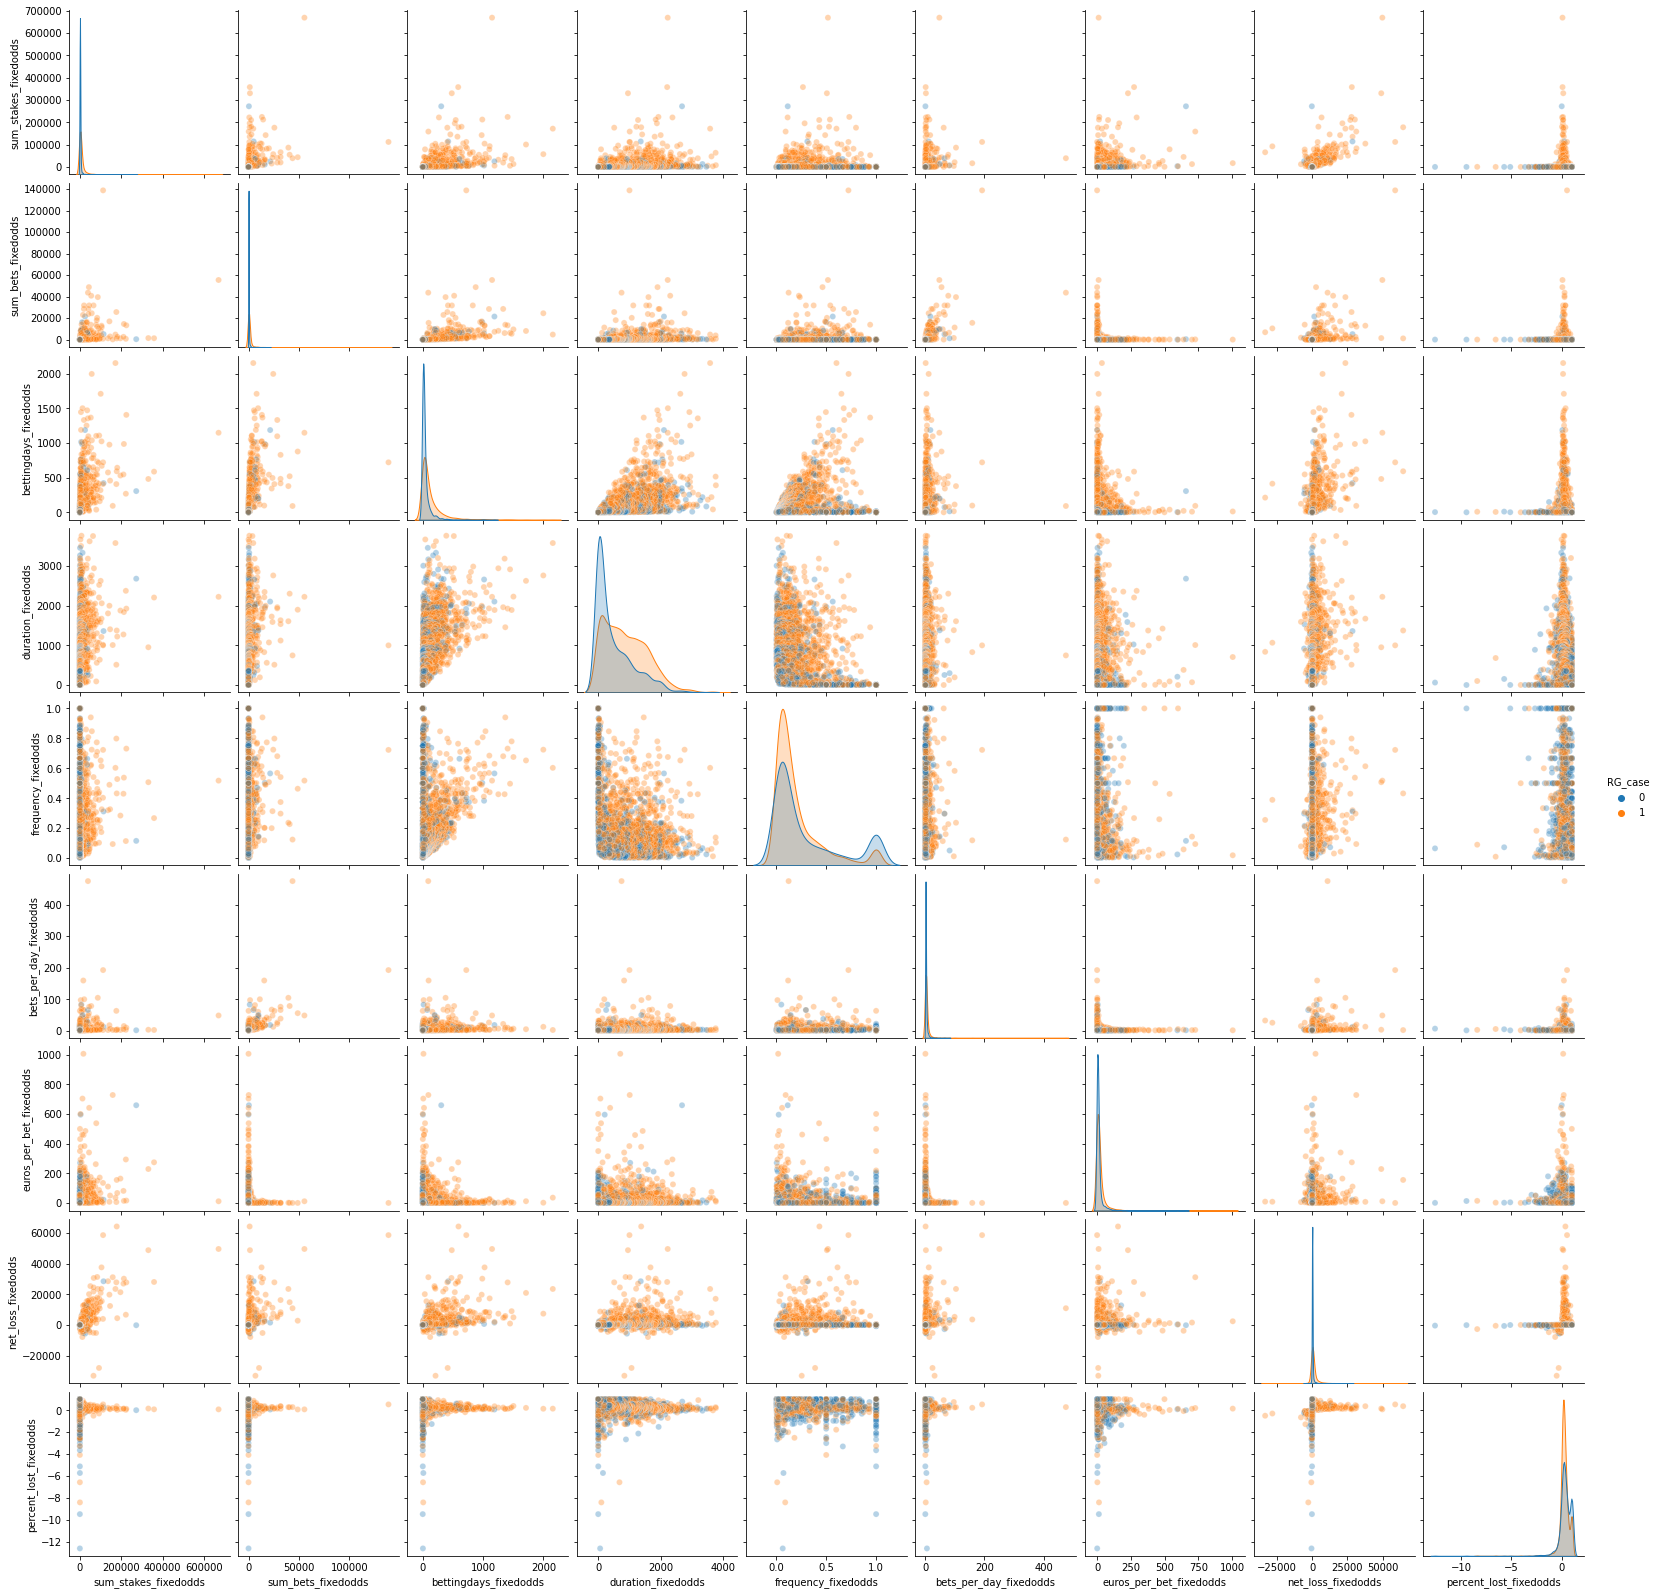

In [10]:
import seaborn as sns

# Specify data types for each column
dtypes = {'sum_stakes_fixedodds': float, 
    'sum_bets_fixedodds': int, 
    'bettingdays_fixedodds': int, 
    'duration_fixedodds': int, 
    'frequency_fixedodds': float, 
    'bets_per_day_fixedodds': float,
    'euros_per_bet_fixedodds': float,
    'net_loss_fixedodds': float,
    'percent_lost_fixedodds': float}

# Change data types of columns
df_analytic = df_analytic.astype(dtypes)

print(df_analytic.info())

sns.pairplot(df_analytic, hue="RG_case", plot_kws={'alpha': 0.33})

Scale the data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform the data
df_analytic_scaled = scaler.fit_transform(df_analytic)

# Preserve the column names
df_analytic_scaled = pd.DataFrame(df_analytic_scaled, columns=df_analytic.columns)

Train the ML model

In [31]:
# Train-test split
from sklearn.model_selection import train_test_split

X = df_analytic.drop(columns=['RG_case'])
y = df_analytic['RG_case']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# I'll try to train a RandomForestClassifier model, and use Gridsearch to find the best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameters to tune and their possible values
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [2, 3, 4, 5],
              'min_samples_split': [2, 5, 7, 10], 
              'min_samples_leaf': [1, 3, 5, 7, 9]}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2)


grid_search.fit(X, y)

best_params = grid_search.best_params_
print(best_params)

# Finally, get the best hyperparameters and train the model.
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=2, min_samples_le

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300)

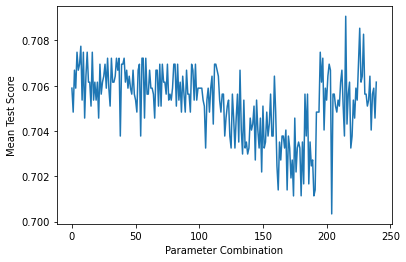

In [14]:
# Plotting the results of the different grisearch combinations
import matplotlib.pyplot as plt

# Get the mean test scores for each combination of parameters
scores = grid_search.cv_results_['mean_test_score']

# Plot the mean test scores for each combination of parameters
plt.plot(range(len(scores)), scores)
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Test Score')
plt.show()


<Figure size 432x288 with 0 Axes>

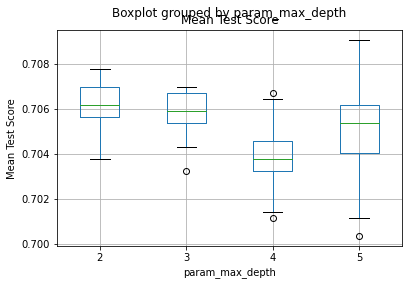

<Figure size 432x288 with 0 Axes>

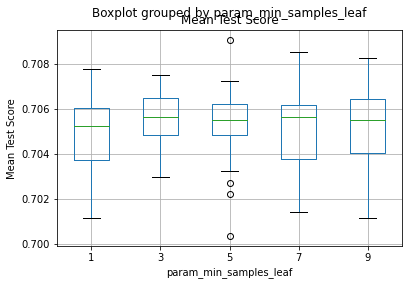

<Figure size 432x288 with 0 Axes>

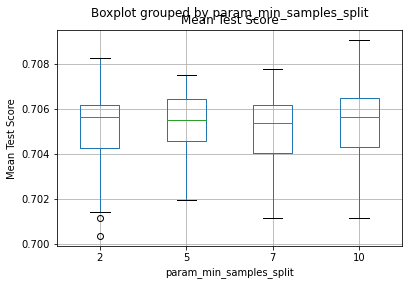

<Figure size 432x288 with 0 Axes>

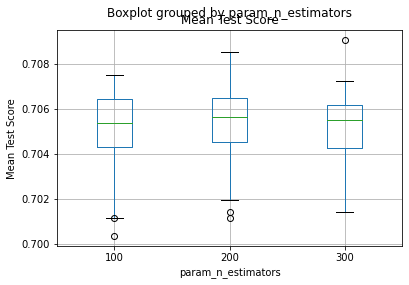

In [15]:
# Plot each hyperparameter individually
results = grid_search.cv_results_

params = ['param_max_depth', 'param_min_samples_leaf', 
          'param_min_samples_split', 'param_n_estimators']

# Extract the mean test score and the hyperparameters values 
mean_test_score = results['mean_test_score']
hyperparameters = [results[param] for param in params]

# Create a dictionary of the hyperparameters and their corresponding mean test scores
df = pd.DataFrame({'Mean Test Score': mean_test_score})
for i, param in enumerate(params):
    df[param] = hyperparameters[i]

# Plot the results
for param in params:
    plt.figure()
    #df.plot(x=param, y='Mean Test Score', kind='scatter')
    df.boxplot(column='Mean Test Score', by=param)
    plt.xlabel(param)
    plt.ylabel('Mean Test Score')
    #plt.title(f'Effect of {param} on Mean Test Score')

plt.show()

Plot the Tree

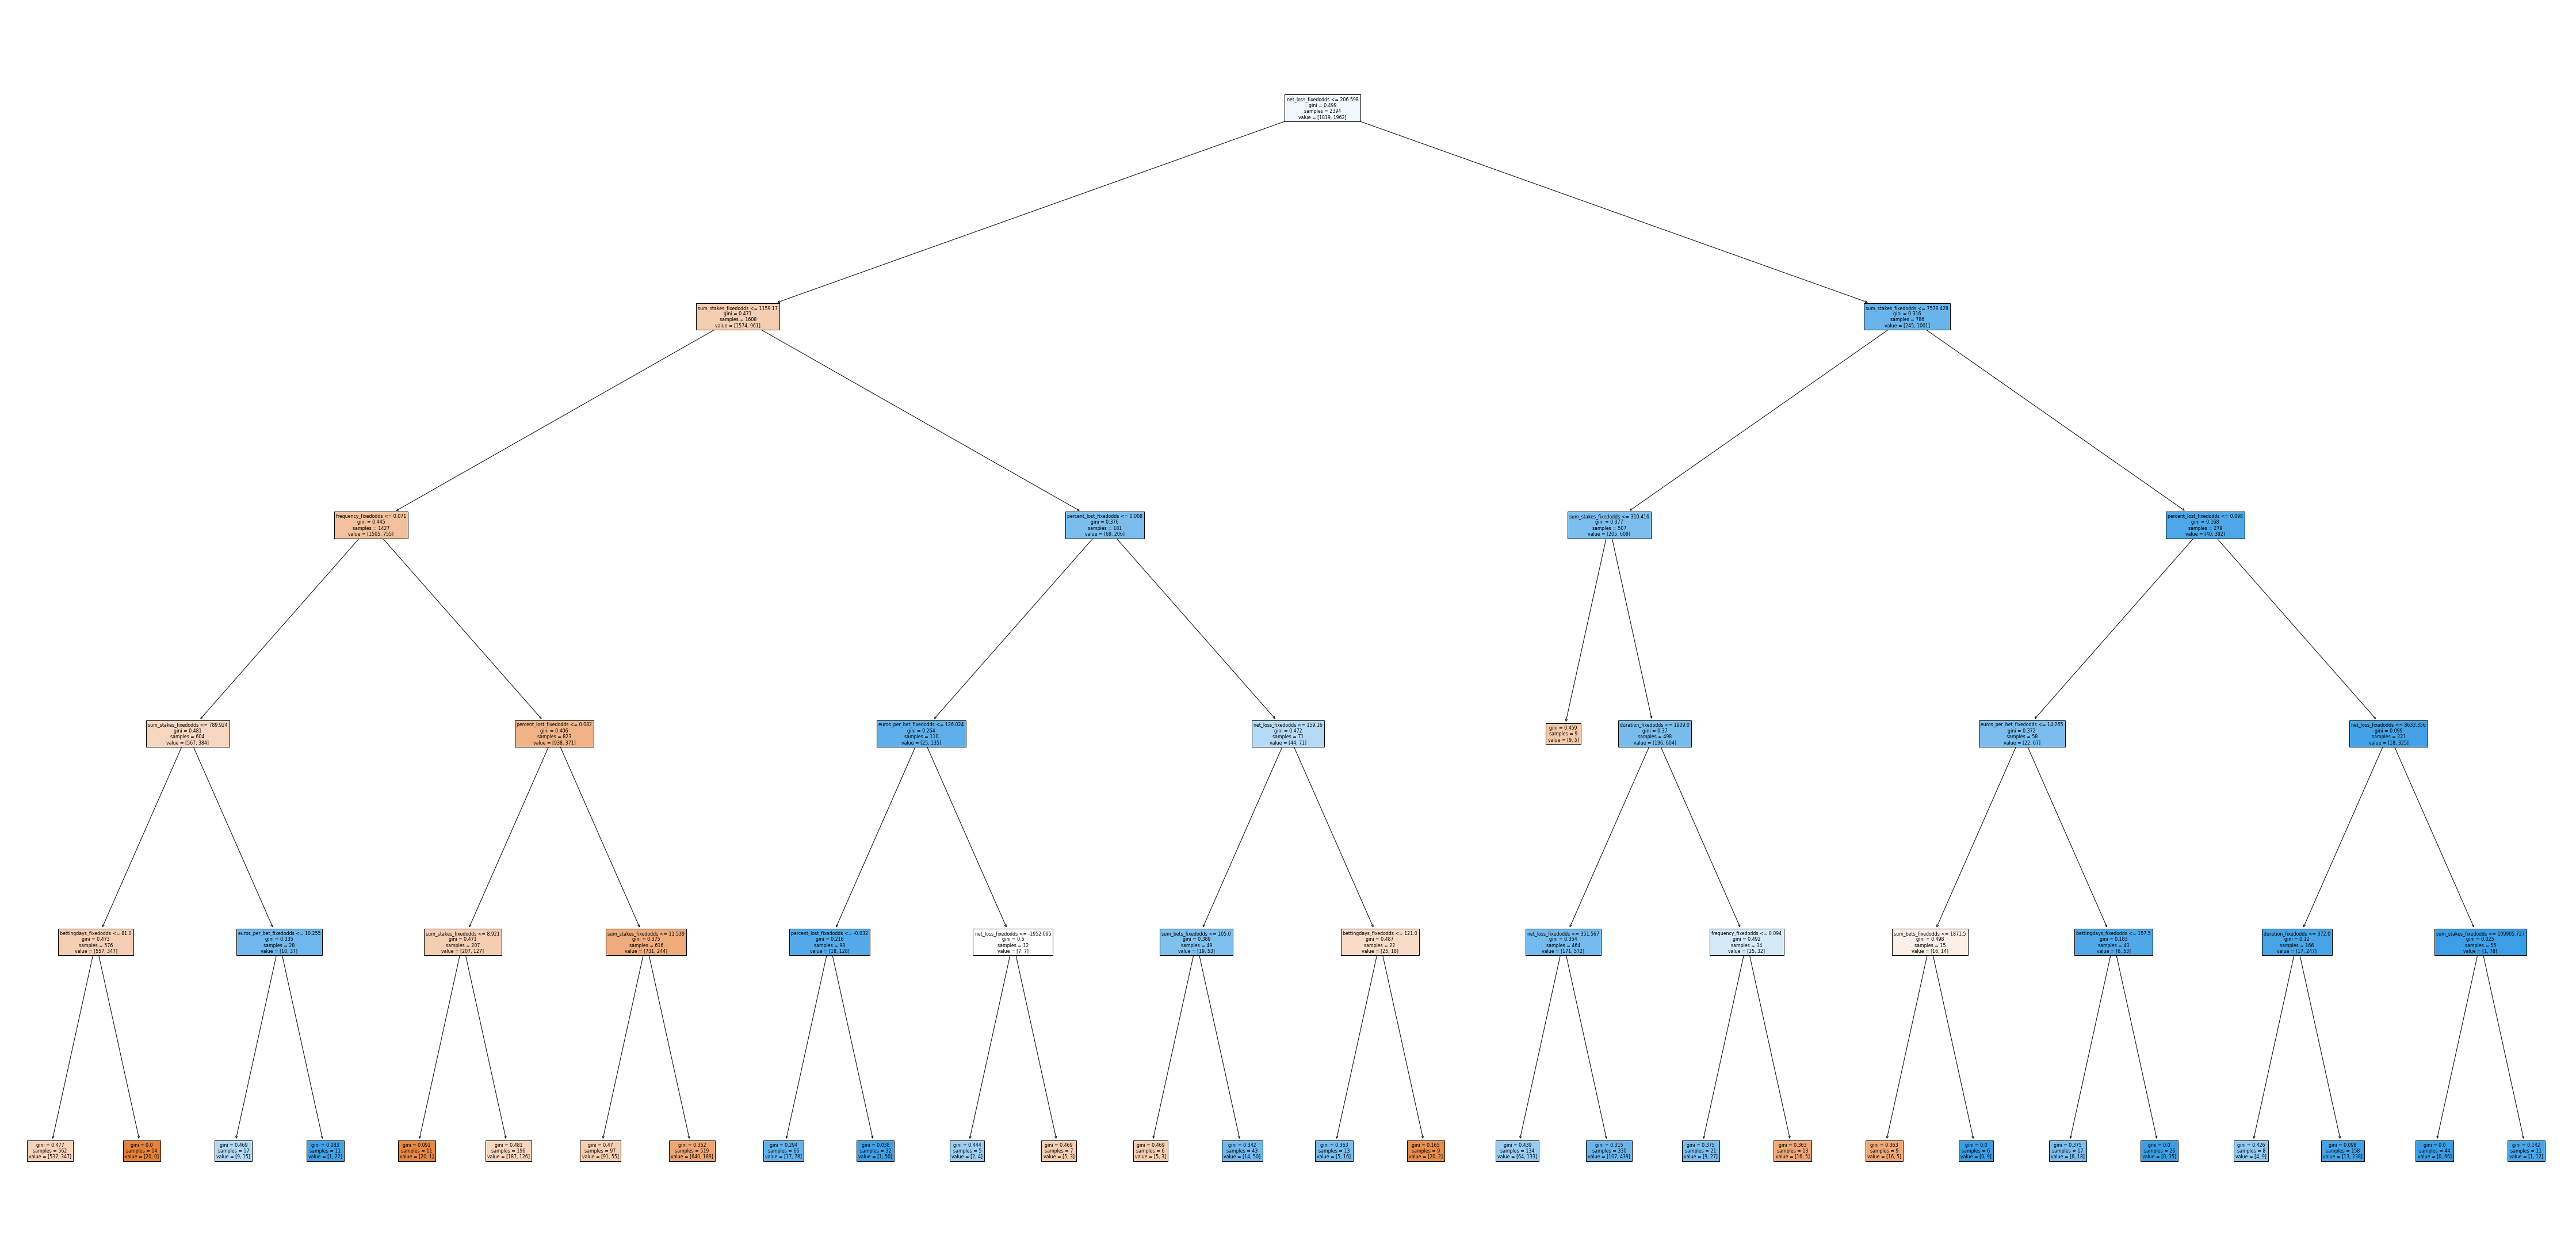

In [16]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[0], filled=True, feature_names=X_train.columns)
plt.show()

Make the predictions and show scores

In [32]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Make the predictions using the test set
y_pred = rf_best.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("R²:", metrics.r2_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Confusion matrix\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7331571994715984
R²: -0.06835743729476706
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       367
           1       0.77      0.69      0.73       390

    accuracy                           0.73       757
   macro avg       0.74      0.73      0.73       757
weighted avg       0.74      0.73      0.73       757

Confusion matrix
 [[285  82]
 [120 270]]


In [ ]:
# Export model to pickle
import pickle

filename = 'randomforestclassifier_gambling.pkl'
pickle.dump(model, open(filename, 'wb'))